# Libraries

In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import copy as cp

from scipy.odr import Model, ODR, RealData

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import healpy as hp

import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples 
import matplotlib.gridspec as gridspec

from pathlib import Path
import more_itertools as mit

import seaborn as sns

In [2]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'

abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Absorption catalog  version 3
print(abs_dr3_data_path)

# Modules

In [ ]:
# import libs.gfitflex as fitlib
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

In [5]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf
from mpfit import mpfit

# For plotting

In [6]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [7]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [8]:
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Number of observed fields

In [9]:
# Exclude some file extensions
# set(glob.glob(os.path.join(LMC_GASKAP_data, '*'))) - set(glob.glob(os.path.join(LMC_GASKAP_data, '*.zip')))

# Only directories/folders
all_dirs = glob.glob( str(hires_abs_data / '*' / '') )

print(f'Number of folders: {len(all_dirs)}')
all_dirs

Number of folders: 10


['/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38373',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38466',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38215',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38814',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38758',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38509',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb33047',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb30665',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38845',
 '/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abs/sb38791']

In [10]:
all_dir_names = [x.replace(str(hires_abs_data), '').replace('/', '') for x in all_dirs]
fields = sorted(list(set([x for x in all_dir_names])))
field_idx = [int(x.replace('sb', '')) for x in fields]
n_fields = len(fields)

print('Number of fields: ', n_fields)
print(fields)

Number of fields:  10
['sb30665', 'sb33047', 'sb38215', 'sb38373', 'sb38466', 'sb38509', 'sb38758', 'sb38791', 'sb38814', 'sb38845']


# Fcn

In [11]:
def boostrap_resampling_err(data):
    # Define the number of bootstrap samples
    n_bootstrap_samples = 1000

    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # Endfor -

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)

    return mean_uncertainty, median_uncertainty

In [12]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

# Read BIGHICAT

In [13]:
bighicat_file = BIGHICAT_data_path / 'all_unique_LOS_new.csv'
bighicat_df = pd.read_csv(bighicat_file)
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

374 30


In [14]:
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,3.072800,308.619949,NaN,0.280609,0.008845,1.0,0.041178,0.001210,0.127653,0.003751,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,2.079000,495.054726,NaN,0.101940,0.003759,1.0,0.028716,0.000767,0.089020,0.002379,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,2.900700,312.439362,NaN,0.170193,0.005946,2.0,0.044000,0.001390,0.136399,0.004308,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN
372,J17422,MACH,81.770200,31.613400,265.597628,54.059010,3.160000,0.060000,0.940000,0.189600,2.970400,682.772331,NaN,0.087578,0.009846,1.0,0.044939,0.001173,0.139312,0.003635,0.046919,0.145447,-13.981676,0.407484,-0.203576,18.122824,0.315143,0.052,NaN,NaN


In [15]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [16]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_av = bighicat_df['AV_2013']

### BIGHICAT high latitudes

In [17]:
blim = 20.

In [18]:
hghlat_df = bighicat_df[abs(bighicat_df.lat) > blim]
hghlat_df.head()

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690


In [19]:
hghlat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [20]:
bighicat_tau = hghlat_df.tau_peak.values
bighicat_sigtau = hghlat_df.tau_sensitivity.values

In [21]:
bighicat_hghlat_fcnm = hghlat_df.f_CNM_LOS.values
bighicat_hghlat_nhi = hghlat_df.NHI_LOS.values

In [22]:
print(hghlat_df.survey.value_counts().sum())
print(hghlat_df.survey.value_counts())

224
GMRT04          75
MACH            44
Millennium03    39
21-SPONGE       36
Per14           16
TauGem19        14
Name: survey, dtype: int64


In [23]:
39+16+36+14+44

149

In [24]:
hghlat_df[hghlat_df.survey == 'GMRT04'].NHI_LOS.values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### BIGHICAT components

In [25]:
bighicat_cpn_file = BIGHICAT_data_path / 'all_unique_CNM_det_gaussian_components_new.csv'
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [26]:
bighicat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [27]:
surveys = bighicat_cpn_df.survey.unique().tolist()
surveys

['21-SPONGE',
 'Millennium03',
 'Per14',
 'GMRT04',
 'TauGem19',
 'RiegelCrutcher18',
 'MACH']

In [28]:
bighicat_cpn_df[bighicat_cpn_df.survey.values == 'GMRT04']

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,Tb,e_Tb,fwhm_em,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
580,J0029+349,GMRT04,117.79,-27.71,0.193,0.005,3.3,0.2,-2.02,0.06,16.10,0.20,5.11,0.05,-3.68,0.01,19.652186,NaN,29.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112010,0.006968,0.347229,0.021600,0.106799,0.331078,42.153801,0.103661,-0.747124,18.336525,0.791807,0.072
581,J0059+001,GMRT04,127.11,-62.70,0.090,0.001,NaN,NaN,-7.60,0.4,3.59,0.09,5.10,0.10,-7.50,0.03,NaN,NaN,42.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024956,0.000654,0.077363,0.002029,0.033897,0.105080,-1.207671,0.916606,-0.903826,19.503107,0.350662,0.037
582,J0116-208,GMRT04,167.11,-81.47,0.030,0.003,NaN,NaN,-5.79,NaN,2.32,0.05,3.70,0.10,-7.15,0.03,NaN,NaN,78.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012237,0.000050,0.037935,0.000155,0.025086,0.077766,-32.375443,0.630477,-0.036304,20.557953,0.057469,0.038
583,J0119+321,GMRT04,129.83,-30.31,0.080,0.040,NaN,NaN,2.80,0.8,8.00,0.20,3.62,0.05,2.81,0.01,NaN,NaN,104.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049503,0.001478,0.153460,0.004582,0.068006,0.210820,-28.962479,0.092936,-0.426188,19.516573,0.401146,0.035
584,J0119+321,GMRT04,129.83,-30.31,0.034,0.007,7.0,5.0,-3.00,3.0,7.90,0.50,6.00,0.10,-3.41,0.04,59.762752,NaN,236.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049503,0.001478,0.153460,0.004582,0.068006,0.210820,-28.962479,0.092936,-0.426188,19.516573,0.401146,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,J2250+143,GMRT04,83.89,-39.20,0.037,0.003,5.0,0.6,-4.20,0.3,5.70,0.10,4.06,0.07,-2.02,0.02,30.903880,NaN,157.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038204,0.001965,0.118433,0.006090,0.055267,0.171328,-0.798115,0.229672,-0.258184,19.773876,0.718693,0.024
671,J2251+188,GMRT04,87.35,-35.65,0.041,0.004,7.3,0.9,-0.30,0.3,14.74,0.08,10.51,0.06,-0.27,0.02,116.873058,NaN,367.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056920,0.001005,0.176451,0.003114,0.066287,0.205490,26.829605,-0.216661,0.007622,19.200924,0.229057,0.045
672,J2251+188,GMRT04,87.35,-35.65,0.015,0.003,22.0,3.0,-9.00,3.0,1.47,0.08,5.40,0.30,-8.60,0.10,34.760880,NaN,99.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056920,0.001005,0.176451,0.003114,0.066287,0.205490,26.829605,-0.216661,0.007622,19.200924,0.229057,0.045
673,J2340+135,GMRT04,97.80,-45.83,0.216,0.005,3.5,0.1,-4.60,0.07,9.10,0.20,15.50,0.10,-4.58,0.07,37.806048,NaN,47.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062863,0.002737,0.194875,0.008483,0.077041,0.238828,15.178831,0.069956,-0.015652,19.052525,0.573459,0.036


In [29]:
bighicat_ts     = bighicat_cpn_df.Ts.values
bighicat_sigts  = bighicat_cpn_df.e_Ts.values
bighicat_tau    = bighicat_cpn_df.tau.values
bighicat_sigtau = bighicat_cpn_df.e_tau.values

bighicat_gb = np.abs(bighicat_cpn_df.lat.values)

# High latitudes

In [34]:
hghlat_cpn_df = bighicat_cpn_df[(abs(bighicat_cpn_df.lat) > blim) & (bighicat_cpn_df.Ts.values < 500.)]
print(hghlat_cpn_df.shape)
hghlat_cpn_df.head()

(413, 41)


,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,Tb,e_Tb,fwhm_em,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,6.904529,0.000000,2.976087,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,25.182555,0.000000,6.006049,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,6.564561,0.890459,2.677941,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,22.468452,0.451441,6.993933,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
7,3C041A,21-SPONGE,131.378783,-29.074651,0.032941,0.000624,8.871778,0.16242071465524413,-1.387832,0.08363020875003654,11.362727,0.000000,9.524291,0.000000,-1.384362,0.000000,1.994321,0.066650,351.823267,7.230769,3.0,5.463896,0.004445,0.092098,0.045187,0.630555,0.024289,3.445285,706.217000,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050


In [ ]:
nsource_hghlat_cpn = 0
hghlat_ncpn = 0
for sv in surveys:
    tmp_df = hghlat_cpn_df[(hghlat_cpn_df.survey.values == sv) & (hghlat_cpn_df.tau.values > 0.)]
    tmp_ts_arr = tmp_df.Ts.values
    tmp_ts_median = np.median(tmp_ts_arr)
    print(sv, ': ncpns', tmp_df.shape, 'ts median: ', tmp_ts_median)
    tmp_nsource = tmp_df.source.unique().shape[0]
    print(tmp_df.source.unique().shape)
    nsource_hghlat_cpn += tmp_nsource
    hghlat_ncpn += tmp_df.shape[0]

    print()
# Endfor 

print('nsources: ', nsource_hghlat_cpn)
print('n_cpns: ', hghlat_ncpn)

In [36]:
bighicat_taucnm = hghlat_cpn_df.tau.values
bighicat_sigtaucnm = hghlat_cpn_df.e_tau.values

bighicat_tscnm = hghlat_cpn_df.Ts.values
bighicat_sigtscnm = hghlat_cpn_df.e_Ts.values

bighicat_cpn_glon = hghlat_cpn_df.lon.values
bighicat_cpn_glat = hghlat_cpn_df.lat.values

In [37]:
bighicat_cpn_glon[bighicat_cpn_glon < 0.] = bighicat_cpn_glon[bighicat_cpn_glon < 0.] + 360.

In [38]:
bighicat_cpn_widwnm = hghlat_cpn_df.fwhm_em.values
bighicat_cpn_sigwidwnm = hghlat_cpn_df.e_fwhm_em.values

### Optical depth ($\tau$)

In [43]:
# Optical depth
bighicat_total_ncnm = len(bighicat_taucnm)
print(f"Total CNM components: {bighicat_total_ncnm}")

Total CNM components: 413


In [44]:
stats_series = pd.DataFrame(bighicat_taucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,413.000000
mean,0.245022
std,0.428383
min,0.002317
25%,0.029000
50%,0.082000
75%,0.286083
max,3.414122


### $T_{spin}$

In [47]:
# Tspin
bighicat_total_ncnm = len(bighicat_tscnm)
print(f"Total CNM components: {bighicat_total_ncnm}")

Total CNM components: 413


In [48]:
stats_series = pd.DataFrame(bighicat_tscnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,413.000000
mean,113.843154
std,106.127933
min,2.000000
25%,43.620000
50%,72.790000
75%,148.000000
max,478.739454


In [51]:
bighicat_tsmin = min(bighicat_tscnm)
bighicat_tsmax = max(bighicat_tscnm)

bighicat_gl_ts  = np.array(bighicat_cpn_glon)
bighicat_gb_ts  = np.array(bighicat_cpn_glat)

bighicat_ind_ts = np.argsort(bighicat_tscnm)
bighicat_ind_ts = bighicat_ind_ts[::-1]
bighicat_tscnm_sorted = bighicat_tscnm[bighicat_ind_ts]
bighicat_gl_ts  = bighicat_gl_ts[bighicat_ind_ts]
bighicat_gb_ts  = bighicat_gb_ts[bighicat_ind_ts]

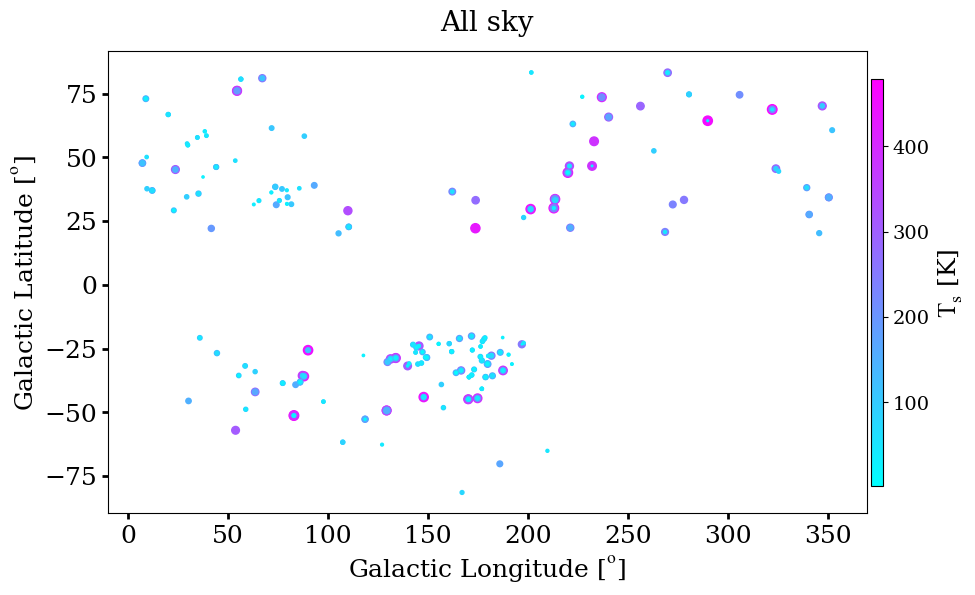

In [52]:
# Plot: Sources with Absorption (LMC foreground)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) # projection=w

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display the moment map image
sct = ax.scatter(bighicat_gl_ts, bighicat_gb_ts,
                  zorder=0, s=bighicat_tscnm_sorted*0.1,
                  c=bighicat_tscnm_sorted, marker='o', cmap=cm,
                  vmin=bighicat_tsmin, vmax=bighicat_tsmax, # transform=ax.get_transform('galactic'),
                  label='')


ploti, = plt.plot([], [], '', label=f"Background: GASS HI column density")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
# ax.invert_xaxis()

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{T_{s}}$ [K]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

plt.title(f"All sky",
          fontsize=20,
          pad=15
         )

plt.legend(loc='lower right', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

# GASKAP Tbpeak

In [ ]:
outfile1 = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
nx1 = 5100
nx2 = 3500

In [ ]:
print(outfile1)
tbpeak_data, fg_hdr = fits.getdata(outfile1, header=True)
print(tbpeak_data.shape)
fg_hdr

# GASKAP: Read table DR3

In [ ]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [54]:
df = df[ df['sbid'].isin(field_idx) ]
nrows, ncols = df.shape
df.shape

(2714, 33)

In [58]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [64]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


In [65]:
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [ ]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

In [68]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


In [70]:
print(f"Types of ratings: {df['rating'].unique()}")

rating_info = df['rating'].value_counts()
rating_types = rating_info.index.to_list()
print(f'Rating types: {rating_types}')

rating_counts = rating_info.values
print(f'Rating counts: {rating_counts}')

n_ratings = len(rating_types)

Types of ratings: ['A' 'B' 'C' 'D']
Rating types: ['B', 'C', 'A', 'D']
Rating counts: [1869  343  294  208]


# Dectections

In [72]:
det_df = df[df.mw_detection]
print(det_df.shape)
ndet = det_df.shape[0]

det_src_list = det_df.comp_name.values
det_src_gl = det_df.glon.values
det_src_gb = det_df.glat.values

(462, 33)


In [73]:
nsrcs

2714

# Saturated sources

In [ ]:
sat_df = df[df.saturated]
sat_df

In [75]:
sat_gl = sat_df.glon.values
sat_gb = sat_df.glat.values

In [76]:
nsat = len(sat_gl)
nsat

12

# Summary: Read table of integrated properties

In [ ]:
csv_filename   = hires_results / 'hires_result_table_dr3.csv' # DR3
gfit_result_df = pd.read_csv(csv_filename)

ndet_total, ncols = gfit_result_df.shape

print('Number of sightlines with detections: ', ndet_total, '| ncols: ', ncols)
gfit_result_df.head(5)

Number of sightlines with detections:  462 | ncols:  42


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.224338,0.257582,0.257582,0.008658,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,1.049632,0.057858,2.232849,0.101853,2.129553,0.064704,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.090102,0.201979,0.201979,0.016992,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.082207,0.131473,2.763580,0.286976,2.553406,0.159735,2,3.573591
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.392247,0.473180,0.473180,0.025034,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.210735,0.368060,2.982020,0.822799,2.489988,0.150394,1,3.564467
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.303581,0.251674,0.251674,0.020553,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.029223,0.063810,2.736283,0.139665,2.665200,0.091393,1,3.485386
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.859835,0.823738,0.823738,0.029911,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,1.004809,0.163384,3.658516,0.577369,3.639773,0.157619,1,3.473220


In [ ]:
gfit_result_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky'],
      dtype='object')

In [ ]:
src_gl = gfit_result_df['glon']
src_gb = gfit_result_df['glat']

gfit_result_df

# Summary: Read table of CNM Gaussian components

In [ ]:
csv_filename = hires_results / 'hires_result_CNM_components_dr3.csv' # DR3
gfit_cpn_result_df = pd.read_csv(csv_filename)

total_ncnm, ncols = gfit_cpn_result_df.shape

print('Number of CNM components detected: ', total_ncnm, '| ncols: ', ncols)
gfit_cpn_result_df.head(5)

Number of CNM components detected:  691 | ncols:  39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.23,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.23,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
gfit_cpn_result_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'taucnm', 'sigtaucnm',
       'sigtaunoise', 'cencnm', 'sigcencnm', 'widcnm', 'sigwidcnm', 'tscnm',
       'sigtscnm', 'tbcnm', 'sigtbcnm', 'nhicnm_cpn', 'signhicnm_cpn',
       'fcnm_cpn', 'sigfcnm_cpn', 'nhi_tot', 'signhi_tot', 'tsky',
       'nhicnm_avg', 'signhicnm_avg'],
      dtype='object')

In [ ]:
# Read all quantities here
fg_taucnm     = gfit_cpn_result_df['taucnm'].values
fg_sigtaucnm  = gfit_cpn_result_df['sigtaucnm'].values
sig_tau_noise = gfit_cpn_result_df['sigtaunoise'].values

glon = gfit_cpn_result_df['glon'].values
glat = gfit_cpn_result_df['glat'].values

tscnm = gfit_cpn_result_df['tscnm'].values
sigtscnm = gfit_cpn_result_df['sigtscnm'].values
nhicnm_cpn = gfit_cpn_result_df['nhicnm_cpn'].values


In [ ]:
print(np.mean(sig_tau_noise))
print(np.median(sig_tau_noise))
print(np.min(sig_tau_noise))
print(np.max(sig_tau_noise))

0.05389575276368301
0.0394858956370871
0.0019152315513153
0.3350685267006879


# Optical depth ($\tau$)

In [ ]:
stats_series = pd.DataFrame(fg_taucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,0.474371
std,0.441789
min,0.014090
25%,0.159337
50%,0.353273
75%,0.646146
max,2.915342


In [ ]:
tau_count = int(series_values[0])
tau_mean = round(series_values[1], 2)
tau_std = round(series_values[2], 2)
tau_minval = round(series_values[3], 4)
tau_maxval = round(series_values[-1], 2)
tau_median = round(series_values[5], 2)
tau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
tau_stats_values = [tau_count, tau_mean, tau_median, tau_std, tau_minval, tau_maxval]

In [ ]:
sig_tau_noise = np.asarray(sig_tau_noise)
low_sigtau_id = np.where(sig_tau_noise < 0.1)[0]
n_low_sigtau_id = len(low_sigtau_id)
hgt_sigtau_id = np.where(sig_tau_noise >= 0.1)[0]
n_hgt_sigtau_id = len(hgt_sigtau_id)

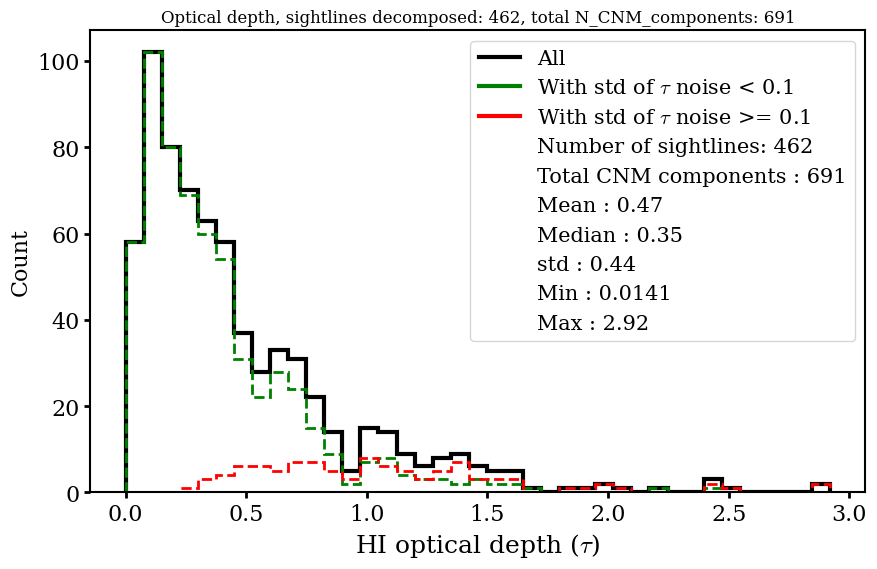

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(fg_taucnm, bins=np.linspace(0., tau_maxval, 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='')

plt.hist(fg_taucnm[low_sigtau_id], bins=np.linspace(0., tau_maxval, 40),
         density=False, color='g', histtype='step', alpha=1.,
         ls='--', lw=2, label='')

plt.hist(fg_taucnm[hgt_sigtau_id], bins=np.linspace(0., tau_maxval, 40),
         density=False, color='r', histtype='step', alpha=1.,
         ls='--', lw=2, label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

ploti, = plt.plot([], [], 'g-', lw=3, label=r'With std of $\tau$ noise < 0.1')
ploti.set_visible(True)

ploti, = plt.plot([], [], 'r-', lw=3, label=r'With std of $\tau$ noise >= 0.1')
ploti.set_visible(True)

ploti, = plt.plot([], [], '', label=f'Number of sightlines: {ndet_total}')
ploti.set_visible(False)
    
for labeli,vali in zip(tau_labels, tau_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)



plt.tick_params(axis='x', labelsize=16, pad=4)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=4)
plt.tick_params(which='minor', length=2)

plt.title(f'Optical depth, sightlines decomposed: {ndet_total}, total N_CNM_components: {total_ncnm}')
plt.xlabel(r'HI optical depth ($\tau$)', fontsize=18)
plt.ylabel(r'Count', fontsize=16)

plt.legend(loc='upper right', fontsize=15)
plt.show()

# Optical depth ($\tau$): low noise

In [ ]:
fg_sigtaucnm_lownoise = fg_sigtaucnm[low_sigtau_id]

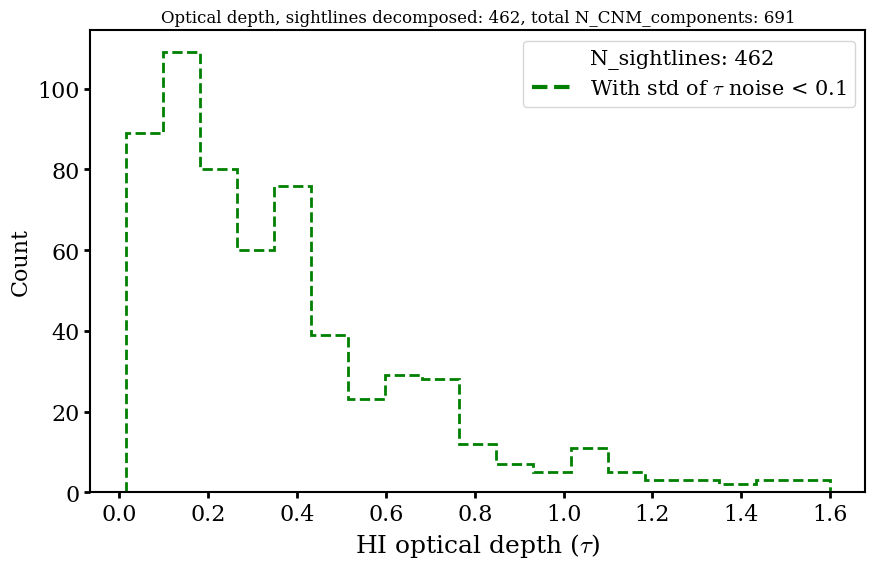

In [ ]:
# from scipy import stats
plt.figure(figsize=(10, 6))

taulow_min = np.min(fg_taucnm[low_sigtau_id])
taulow_max = np.max(fg_taucnm[low_sigtau_id])

counts, bins, bars = plt.hist(fg_taucnm[low_sigtau_id], bins=np.linspace(taulow_min, 1.6, 20),
         density=False, color='g', histtype='step', alpha=1.,
         ls='--', lw=2, label='')

ploti, = plt.plot([], [], '', label=f'N_sightlines: {ndet_total}')
ploti.set_visible(False)


ploti, = plt.plot([], [], 'g--', lw=3, label=r'With std of $\tau$ noise < 0.1')
ploti.set_visible(True)

plt.tick_params(axis='x', labelsize=16, pad=4)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=4)
plt.tick_params(which='minor', length=2)

plt.title(f'Optical depth, sightlines decomposed: {ndet_total}, total N_CNM_components: {total_ncnm}')
plt.xlabel(r'HI optical depth ($\tau$)', fontsize=18)
plt.ylabel(r'Count', fontsize=16)

plt.legend(loc='upper right', fontsize=15)
plt.show()

In [ ]:
print(len(counts))
counts

In [ ]:
print(len(bins))
bins

In [ ]:
xbins = bins[:-1] + np.diff(bins)/2
xbins

In [ ]:
# from scipy import stats
xbins_ln = np.log(xbins)
ycounts_ln = np.log(counts)

In [ ]:
idx_zero = np.where(ycounts_ln == 0)[0]
ycounts_ln[idx_zero] = ycounts_ln[idx_zero] + 1.e-3
ycounts_ln

In [ ]:
# Create a model for fitting.
linear_model = Model(linear_fcn)

# Create a RealData object using our initiated data from above.
data = RealData(xbins, ycounts_ln, sx=xbins*0.1, sy=ycounts_ln*0.1)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-1., 5.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

x_fit = np.linspace(0., 1.6, 50)
y_fit = linear_fcn(out.beta, x_fit)

Beta: [-3.02028236  5.05618671]
Beta Std Error: [0.20259498 0.18544117]
Beta Covariance: [[ 0.04980306 -0.04074268]
 [-0.04074268  0.04172641]]
Residual Variance: 0.8241405807596225
Inverse Condition #: 0.21438170774782658
Reason(s) for Halting:
  Sum of squares convergence


In [ ]:
# Optical depth
taumin = min(fg_taucnm)
taumax = max(fg_taucnm)

gl_tau  = np.array(glon)
gb_tau  = np.array(glat)

ind_tau = np.argsort(fg_taucnm)
ind_tau = ind_tau[::-1]
taucnm_sorted = fg_taucnm[ind_tau]
gl_tau = gl_tau[ind_tau]
gb_tau = gb_tau[ind_tau]

In [ ]:
mean_std, median_std = boostrap_resampling_err(fg_taucnm)
print(mean_std, median_std)

0.016315046197184442 0.015696717991036363


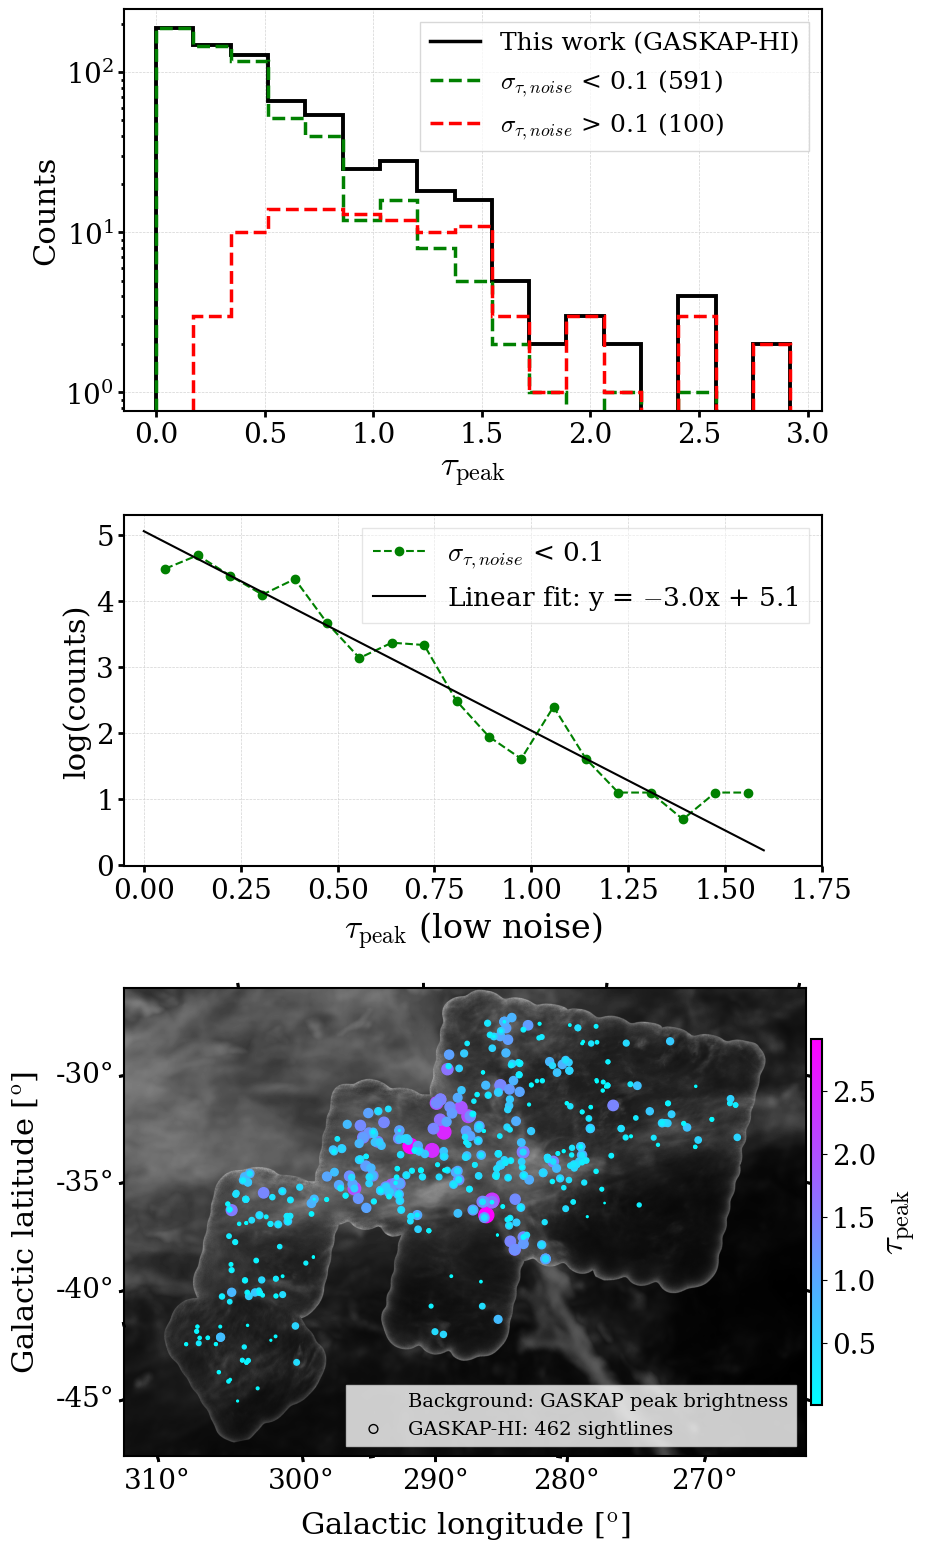

In [ ]:
# import matplotlib.gridspec as gridspec

xylabel = 22
xytlabel = 20
lgsize = 14

# Create a figure with gridspec
mpl.rcParams['axes.linewidth'] = 1.5

fig = plt.figure(figsize=(9., 19.))

gs = gridspec.GridSpec(3, 1, height_ratios=[0.8, 0.7, 1])

# Plot the first panel
ax1 = fig.add_subplot(gs[0])
nbins = 18

cnts, bins, _ = ax1.hist(fg_taucnm, bins=np.linspace(0., tau_maxval, nbins),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=2.8,
         label='')

ploti, = ax1.plot([], [], 'k-', lw=2.5, label=f'This work (GASKAP-HI)')
ploti.set_visible(True)


ax1.hist(fg_taucnm[low_sigtau_id], bins=np.linspace(0., tau_maxval, nbins),
         density=False, color='g', histtype='step', alpha=1.,
         ls='--', lw=2.5, label='')

ax1.hist(fg_taucnm[hgt_sigtau_id], bins=np.linspace(0., tau_maxval, nbins),
         density=False, color='r', histtype='step', alpha=1.,
         ls='--', lw=2.5, label='')

    
ploti, = ax1.plot([], [], 'g--', lw=2.5, label=r'$\sigma_{\tau, noise}$ < 0.1 (' + str(n_low_sigtau_id) + ')')
ploti.set_visible(True)

ploti, = ax1.plot([], [], 'r--', lw=2.5, label=r'$\sigma_{\tau, noise}$ > 0.1 (' + str(n_hgt_sigtau_id) + ')')
ploti.set_visible(True)


ax1.set_yscale('log')




ax1.set_ylabel(r'Counts', fontsize=xylabel)
ax1.set_xlabel(r'$\tau_\mathrm{peak}$', fontsize=xylabel+3)

ax1.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax1.tick_params(axis='y', labelsize=xytlabel)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax1.legend(loc='upper right', fancybox=False, framealpha=0.75, labelcolor='k', fontsize=lgsize+4)



# Plot the second panel
ax2 = fig.add_subplot(gs[1])
ax2.plot(xbins, ycounts_ln, 'go--', label=r'$\sigma_{\tau,noise}$ < 0.1')
ax2.plot(x_fit, y_fit, 'k-', label=f'Linear fit: y = $-$3.0x + {round(out.beta[1], 1)}')


ax2.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax2.tick_params(axis='y', labelsize=xytlabel)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.set_xlim(-0.05, 1.75)

ax2.set_xlabel(r'$\tau_\mathrm{peak}$ (low noise)', fontsize=xylabel+2)
ax2.set_ylabel(r'log(counts)', fontsize=xylabel)
ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax2.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=lgsize+5)





# Plot the third panel
ax3 = fig.add_subplot(gs[2], projection=WCS(fg_hdr))

# Display the moment map image
im = ax3.imshow(tbpeak_data, origin='lower', cmap='gray')

sct = ax3.scatter(gl_tau, gb_tau,
                  zorder=1,
                  c=taucnm_sorted, s=taucnm_sorted*40., marker='o', cmap=cm,
                  vmin=taumin, vmax=taumax,
                  transform=ax3.get_transform('galactic'),
                  label=r'')


ploti, = ax3.plot([], [], '', label=f"Background: GASKAP peak brightness")
ploti.set_visible(False)

ploti = ax3.scatter([], [], marker='o', s=40, edgecolors='k', facecolors='none', label=f'GASKAP-HI: {ndet} sightlines')
ploti.set_visible(True)

# Add axes labels
ax3.set_xlabel(r"Galactic longitude [$^\mathrm{o}$]", fontsize=xylabel)
ax3.set_ylabel(r"Galactic latitude [$^\mathrm{o}$]", fontsize=xylabel)


ax3.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax3.tick_params(axis='y', labelsize=xytlabel)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct, ax=ax3, orientation='vertical', fraction=0.015, pad=0.0075, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{\tau_{peak}}$', rotation=90, labelpad=5., fontsize=25)
cbar.ax.tick_params(labelsize=20)

ax3.legend(loc='lower right', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=lgsize)





# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.25
                    )

plt.show()


# Optical depth PDFs

In [ ]:
hghlat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [ ]:
perseus_datafile = BIGHICAT_data_path / 'SF14_params.csv'
per_cpn_df = pd.read_csv(perseus_datafile)
per_cpn_df['CNM'] = (per_cpn_df.e_Ts > -0.1)
per_cpn_df

,ID,TB,e_TB,VLSR,e_VLSR,DelV,e_DelV,tau,e_tau,Ts,e_Ts,Tkmax,NHI,ForO,CNM
0,3C067,1.88,0.06,-25.8,0.1,4.71,0.18,0.006,-99.000,331.00,-999.00,835,0.17,1.0,False
1,3C067,1.95,0.00,-11.6,0.4,41.30,0.64,0.004,-99.000,438.00,-999.00,2077,1.27,0.0,False
2,3C067,5.34,-9.00,-5.8,0.1,4.81,0.18,0.096,0.002,69.10,8.88,325,0.62,2.0,True
3,3C067,21.02,0.35,-2.3,0.2,9.75,0.17,0.017,-99.000,1254.00,-999.00,861,3.99,0.5,False
4,3C067,23.05,-9.00,-0.3,0.0,2.14,0.04,0.412,0.008,42.88,8.28,607,0.74,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,NV0232+34,2.69,0.03,-6.5,0.1,39.32,0.37,0.011,-99.000,245.00,-999.00,33787,1.68,0.0,False
178,NV0232+34,20.16,-9.00,-1.9,0.1,2.04,0.16,0.130,0.010,43.04,8.28,607,0.22,0.0,True
179,NV0232+34,22.52,-9.00,-0.1,0.2,8.49,0.71,0.058,0.014,321.07,8.88,325,3.10,2.0,True
180,NV0232+34,22.90,-9.00,0.4,0.0,1.82,0.09,0.200,0.012,37.38,14.82,489,0.27,3.0,True


In [ ]:
per_cpn_df = per_cpn_df[per_cpn_df.CNM]
per_cpn_df

,ID,TB,e_TB,VLSR,e_VLSR,DelV,e_DelV,tau,e_tau,Ts,e_Ts,Tkmax,NHI,ForO,CNM
2,3C067,5.34,-9.0,-5.8,0.1,4.81,0.18,0.096,0.002,69.10,8.88,325,0.62,2.0,True
4,3C067,23.05,-9.0,-0.3,0.0,2.14,0.04,0.412,0.008,42.88,8.28,607,0.74,0.0,True
5,3C067,17.71,-9.0,1.2,0.1,5.99,0.13,0.186,0.005,89.34,14.82,489,1.94,1.0,True
8,3C068.2,5.09,-9.0,-6.2,0.0,2.58,0.07,0.270,0.000,19.75,8.88,144,0.27,0.0,True
9,3C068.2,-0.09,-9.0,-3.0,0.1,2.63,0.24,0.088,0.004,4.11,8.28,151,0.02,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NV0157+28,13.69,-9.0,-0.5,0.0,1.96,0.12,0.040,0.002,25.80,8.28,607,0.04,0.0,True
178,NV0232+34,20.16,-9.0,-1.9,0.1,2.04,0.16,0.130,0.010,43.04,8.28,607,0.22,0.0,True
179,NV0232+34,22.52,-9.0,-0.1,0.2,8.49,0.71,0.058,0.014,321.07,8.88,325,3.10,2.0,True
180,NV0232+34,22.90,-9.0,0.4,0.0,1.82,0.09,0.200,0.012,37.38,14.82,489,0.27,3.0,True


In [ ]:
per_cpn_df.ID.unique().shape

(26,)

In [ ]:
mil_datafile = BIGHICAT_data_path / 'nhi_lb_79src_HT03.csv'
mil_df = pd.read_csv(mil_datafile)
mil_df

,ID,source,l,b,nhi nhi_er thin,thin_er,cnm,cnm_er,Unnamed: 8,wnm,Unnamed: 10,wnm_er
0,0,3C33,129.4481,-49.3244,2.7800,0.0400,2.8239,0.0680,1.64,0.0232,1.1400,0.0357
1,1,3C18,118.6218,-52.7266,5.9900,0.9500,5.1766,0.0315,5.24,0.9450,0.7500,0.0561
2,2,3C141.0,174.5324,-1.3112,52.6900,1.4800,40.9027,0.5363,23.64,1.2509,29.0500,0.7996
3,3,3C142.1,197.6157,-14.5115,21.9600,2.3000,17.2260,0.7261,8.10,2.2459,13.8600,0.5171
4,4,3C138,187.4052,-11.3437,19.8400,0.9900,17.4826,0.2399,10.69,0.9004,9.1500,0.4088
...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,P0320+05,176.9818,-40.8433,11.2000,0.4800,9.9975,0.7438,5.05,0.3183,6.1500,0.3610
75,75,3C274.1,269.8744,83.1637,2.3600,0.0400,2.2860,0.1201,0.30,0.0193,2.0600,0.0293
76,76,3C207,212.9680,30.1390,5.2500,0.1500,4.9461,0.0969,0.91,0.1267,4.3400,0.0870
77,77,T0629+10,201.5315,0.5079,59.2500,2.8600,45.1748,0.1705,37.02,2.5766,22.2300,1.2404


In [ ]:
mil_datafile = BIGHICAT_data_path / 'cpn_params_HT03.csv'
mil_cpn_df = pd.read_csv(mil_datafile)
mil_cpn_df = mil_cpn_df.merge(mil_df[['source', 'l', 'b']], on='source', how='left')
mil_cpn_df['isCNM'] = (mil_cpn_df.Tser > -0.1)
mil_cpn_df = mil_cpn_df[np.abs(mil_cpn_df.b.values) > 9.5]
mil_cpn_df = mil_cpn_df[mil_cpn_df.isCNM]
mil_cpn_df = mil_cpn_df[mil_cpn_df.tau < 4.]
mil_cpn_df

,Tpeak,Ter,tau,tauer,Vlsr,Ver,delV,dVer,Tspin,Tser,Tkmax,NHI,NHIer,CNM,Frac,Fer,source,l,b,isCNM
1,16.71,-12.0,0.669,0.011,-8.9,0.0,2.43,0.03,34.25,7.89,129.0,1.09,0.2498,1,-18.0,-18.0,3C18,118.6218,-52.7266,True
2,19.80,-12.0,0.077,0.019,-6.7,0.2,8.62,0.70,267.80,5.28,1625.0,3.46,0.8983,0,-18.0,-18.0,3C18,118.6218,-52.7266,True
3,8.09,-12.0,0.181,0.018,-5.7,0.1,3.98,0.25,48.75,9.41,346.0,0.69,0.1540,2,-18.0,-18.0,3C18,118.6218,-52.7266,True
5,10.41,-12.0,0.034,0.001,-4.6,0.1,9.44,0.30,309.63,4.79,1949.0,1.95,0.0886,0,-18.0,-18.0,3C33-1,129.4392,-49.3432,True
7,10.20,-12.0,0.059,0.002,-4.2,0.2,9.31,0.42,177.85,4.54,1892.0,1.90,0.1174,0,-18.0,-18.0,3C33-2,129.4620,-49.2774,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,19.33,-12.0,1.132,0.016,3.2,0.0,3.42,0.04,28.52,19.69,255.0,2.15,1.4793,2,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
339,24.22,-12.0,1.318,0.040,9.2,0.0,3.70,0.05,33.07,18.46,298.0,3.14,1.7494,1,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
340,21.22,-12.0,2.346,0.128,10.6,0.0,1.50,0.05,23.47,9.38,49.0,1.61,0.6485,0,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
352,1.47,-12.0,0.010,0.001,-4.6,0.1,7.94,0.30,149.01,6.39,1379.0,0.23,0.0264,1,-18.0,-18.0,P1055+20,222.5101,63.1302,True


In [ ]:
spo_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[0]]
spo_cpn_df = spo_cpn_df[np.isfinite(spo_cpn_df.Ts.values)]
# spo_cpn_df.Ts.max()
spo_cpn_df

,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,Tb,e_Tb,fwhm_em,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
0,1055+018,21-SPONGE,-108.489395,52.773983,0.006418,0.000211,7.061405,0.2533794334354352,-7.276518,0.1093717782616211,6.014311,0.000000,7.043752,0.000000,-6.843069,0.000000,0.827511,0.048499,941.344712,30.798667,1.0,2.943138,0.000000,0.003878,0.018140,0.718834,0.000000,2.115627,2540.335139,0.025512,0.000373,0.079088,0.001155,0.036975,0.114623,16.987488,5.668997,-10.984881,19.149420,0.188328,0.046
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,6.904529,0.000000,2.976087,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,25.182555,0.000000,6.006049,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,6.564561,0.890459,2.677941,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,22.468452,0.451441,6.993933,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,PKS1607,21-SPONGE,44.171276,46.203208,0.013369,0.000371,6.486483,0.3040040241598035,-7.795565,0.21806072040848215,1.444729,0.000000,7.151348,0.000000,-7.795565,0.000000,0.192770,0.021173,114.607548,10.930104,4.0,3.877342,0.229105,0.352060,0.163394,0.770895,0.888318,2.989024,229.487050,0.050723,0.002395,0.157243,0.007426,0.065415,0.202786,-44.153637,-0.355844,0.682174,19.348246,0.637820,0.048
275,PKS2127,21-SPONGE,58.652068,-31.814925,0.107217,0.000993,2.143175,0.020048405232085776,1.526260,0.01140268378850735,5.750364,0.000000,2.036016,0.000000,1.490007,0.000000,0.273887,0.023195,61.449708,5.140834,3.0,4.714311,0.142179,0.161311,0.077554,0.520398,0.670274,2.453320,454.743857,0.064037,0.003025,0.198516,0.009379,0.066924,0.207465,22.407097,0.204960,-0.190081,19.260256,0.634114,0.059
276,PKS2127,21-SPONGE,58.652068,-31.814925,0.072757,0.000702,2.667177,0.038243329322583355,-0.886340,0.02112560248226647,7.618268,0.000000,2.712752,0.000000,-0.885295,0.000000,0.396387,0.016852,105.308706,4.090423,3.0,4.714311,0.142179,0.161311,0.077554,0.520398,0.670274,2.453320,454.743857,0.064037,0.003025,0.198516,0.009379,0.066924,0.207465,22.407097,0.204960,-0.190081,19.260256,0.634114,0.059
277,PKS2127,21-SPONGE,58.652068,-31.814925,0.012796,0.000727,8.329176,0.2107201854834028,1.088381,0.0835187453913894,9.734887,0.000000,8.329176,0.000000,1.199940,0.000000,1.590718,0.133745,769.461638,43.556803,3.0,4.714311,0.142179,0.161311,0.077554,0.520398,0.670274,2.453320,454.743857,0.064037,0.003025,0.198516,0.00937

In [ ]:
# SPONGE
spo_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[0]]
spo_cpn_df = spo_cpn_df[np.isfinite(spo_cpn_df.Ts.values)]
spo_cpn_df = spo_cpn_df[abs(spo_cpn_df.lat) > 9.5]
spo_cpn_ts = spo_cpn_df.tau.values
spo_cpn_sigts = spo_cpn_df.e_tau.values
spo_ncnm = spo_cpn_sigts.shape[0]
print(surveys[0], 'SPONGE', spo_ncnm, 'CNM components')

# Millennium03
mil_cpn_ts = mil_cpn_df.tau.values
mil_cpn_sigts = mil_cpn_df.tauer.values
mil_ncnm = mil_cpn_ts.shape[0]
print(surveys[1], 'Millennium03', mil_ncnm)

# Per14
per_cpn_ts = per_cpn_df.tau.values
per_cpn_sigts = per_cpn_df.e_tau.values
per_ncnm = per_cpn_ts.shape[0]
print(surveys[2], 'Per14', per_ncnm)

# GMRT04
gmr_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[3]]
gmr_cpn_ts = gmr_cpn_df.tau.values
gmr_cpn_sigts = gmr_cpn_df.e_tau.values
gmr_ncnm = gmr_cpn_ts.shape[0]
print(surveys[3], 'GMRT04', gmr_ncnm)

# TauGem19
gno_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[4]]
gno_cpn_ts = gno_cpn_df.tau.values
gno_cpn_sigts = gno_cpn_df.e_tau.values
gno_ncnm = gno_cpn_ts.shape[0]
print(surveys[4], 'TauGem19', gno_ncnm)


# MACH
mac_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == surveys[6]]
mac_cpn_ts = mac_cpn_df.tau.values
mac_cpn_sigts = mac_cpn_df.e_tau.values
mac_ncnm = mac_cpn_ts.shape[0]
print(surveys[6], 'MACH', mac_ncnm)

21-SPONGE SPONGE 140 CNM components
Millennium03 Millennium03 153
Per14 Per14 107
GMRT04 GMRT04 95
TauGem19 TauGem19 315
MACH MACH 19


In [ ]:
mil_nlos = mil_cpn_df.source.unique().shape[0]
per_nlos = per_cpn_df.ID.unique().shape[0]
spo_nlos = spo_cpn_df.source.unique().shape[0]
print(surveys[1], mil_nlos, 'lines-of-sight')
print(surveys[2], per_nlos)
print(surveys[0], spo_nlos)
print(mil_nlos+per_nlos+spo_nlos, 'lines-of-sight')
print(mil_ncnm+per_ncnm+spo_ncnm, 'CNM components')


Millennium03 51 lines-of-sight
Per14 26
21-SPONGE 40
117 lines-of-sight
400 CNM components


In [ ]:
gno_nlos = gno_cpn_df.source.unique().shape[0]
gmr_nlos = gmr_cpn_df.source.unique().shape[0]
mac_nlos = mac_cpn_df.source.unique().shape[0]
print(gno_nlos, gno_nlos, 'lines-of-sight')
print(gmr_nlos, gmr_nlos)
print(mac_nlos, mac_nlos)
print(mil_nlos+per_nlos+spo_nlos+gno_nlos+gmr_nlos+mac_nlos, 'lines-of-sight')

71 71 lines-of-sight
60 60
16 16
264 lines-of-sight


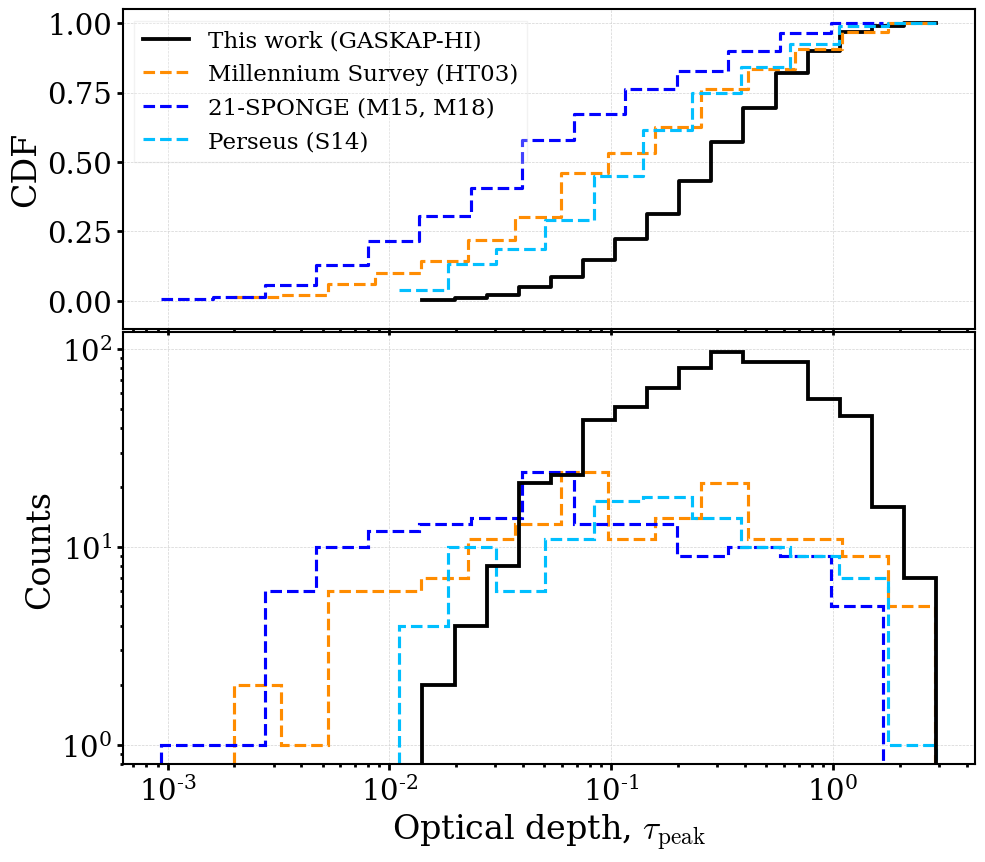

In [ ]:
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.linewidth'] = 1.5


lw = 2.25
binx = [15, 16, 12, 10, 5, 3]
linesty = '--' 
colors = ['b', 'darkorange', 'deepskyblue', 'gray', 'black', 'skyblue']
survey_labels = ['21-SPONGE (M15, M18)', 'Millennium Survey (HT03)', 'Perseus (S14)', 'GMRT04', 'GNOMES', 'MACH']


xylabel = 24
xytlabel = 21


# Figure
fig = plt.figure(figsize=(11,10))
gs = gridspec.GridSpec(7, 10)
ax = plt.subplot(gs[3:7, 0:10])
ax_cdf = plt.subplot(gs[0:3, 0:10],sharex=ax)


ploti, = ax.plot([], [], 'k-', lw=lw+0.5, label='This work (GASKAP-HI)')
ploti.set_visible(True)





mil_cnts, mil_bins, _ = ax.hist(mil_cpn_ts, bins = 10**np.linspace(np.log10(np.min(mil_cpn_ts)), np.log10(np.max(mil_cpn_ts)), binx[1]), color=colors[1],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[1], ls=linesty, lw=lw, label=survey_labels[1])
ploti.set_visible(True)

spo_cnts, spo_bins, _ = ax.hist(spo_cpn_ts, bins = 10**np.linspace(np.log10(np.min(spo_cpn_ts)), np.log10(np.max(spo_cpn_ts)), binx[0]), color=colors[0],
         density=False,  histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[0], ls=linesty, lw=lw, label=survey_labels[0])
ploti.set_visible(True)


per_cnts, per_bins, _ = ax.hist(per_cpn_ts, bins = 10**np.linspace(np.log10(np.min(per_cpn_ts)), np.log10(np.max(per_cpn_ts)), binx[2]), color=colors[2],
         density=False, histtype='step',
         alpha=1., ls=linesty, lw=lw,
         label='')
ploti, = ax.plot([], [], colors[2], ls=linesty, lw=lw, label=survey_labels[2])
ploti.set_visible(True)


cnts, bins, _ = ax.hist(fg_taucnm, bins = 10**np.linspace(np.log10(np.min(fg_taucnm)), np.log10(np.max(fg_taucnm)), 17),
         density=False, color='k',
         alpha=1., ls='-', lw=lw+0.5, histtype='step',
         label='')

ax.set_xlabel(r'Optical depth, $\tau_\mathrm{peak}$', fontsize=xylabel)
ax.set_ylabel('Counts', fontsize=xylabel)

ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax.tick_params(axis='y', labelsize=xytlabel)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

ax.set_yscale('log')
ax.set_xscale('log')



# Top
cdf = np.cumsum(cnts)/np.sum(cnts)
ax_cdf.set_ylabel('CDF', fontsize=xylabel)

ax_cdf.plot(
    np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
    np.vstack((cdf, cdf)).T.flatten(),
    color='k', ls='-', lw=lw+0.5,
    alpha=0.99, label='This work (GASKAP-HI)',
)




cdf3 = np.cumsum(mil_cnts)/np.sum(mil_cnts)

ax_cdf.plot(
    np.vstack((mil_bins, np.roll(mil_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[1], ls=linesty, lw=lw,
    alpha=0.99, label=survey_labels[1]
)


cdf3 = np.cumsum(spo_cnts)/np.sum(spo_cnts)

ax_cdf.plot(
    np.vstack((spo_bins, np.roll(spo_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[0], ls=linesty, lw=lw,
    alpha=0.99, label=survey_labels[0]
)

cdf3 = np.cumsum(per_cnts)/np.sum(per_cnts)

ax_cdf.plot(
    np.vstack((per_bins, np.roll(per_bins, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[2], ls=linesty, lw=lw,
    alpha=0.99, label=survey_labels[2]
)




ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax_cdf.tick_params(axis='y', labelsize=xytlabel)
ax_cdf.tick_params(which='both', width=2)
ax_cdf.tick_params(which='major', length=4)
ax_cdf.tick_params(which='minor', length=2)

ax_cdf.set_ylim(-0.1,1.05)

ax_cdf.tick_params('y', colors='k')
ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
plt.setp(ax_cdf.get_xticklabels(), visible=False)

ax_cdf.legend(loc='upper left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)


# Adjust the position of the second panel
pos2 = ax.get_position()
ax.set_position([pos2.x0, pos2.y0 + 0.015, pos2.width, pos2.height])



plt.show()